## Initialize the environment

In [26]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv('Occupancy_Estimation.csv')

## Question 1: Proportion Test for Sound Spikes

**Goal:** 95% CI for $p=\Pr[S1\_Sound>1]$, test $H_0:p=0.025$.

1. **Count spikes**:

In [27]:
spikes = (df["S1_Sound"] > 1).sum()
n = len(df)
phat = spikes / n

print(f"Total samples: {n}")
print(f"Spikes: {spikes}")
print(f"Sample proportion (p̂): {phat:.5f}")

Total samples: 10129
Spikes: 280
Sample proportion (p̂): 0.02764


2. **Check normal approx**: ensure $n p_0\ge10$ and $n(1-p_0)\ge10$.

In [28]:
p0 = 0.025
np0 = n * p0
nq0 = n * (1 - p0)
print(f"np0 = {np0}, n(1-p0) = {nq0}")
print("Normal approximation is valid." if np0 >= 10 and nq0 >= 10 else "Normal approximation is NOT valid.")

np0 = 253.22500000000002, n(1-p0) = 9875.775
Normal approximation is valid.


3. **95% CI** (Wald):

   $$
     \hat p \pm z_{0.975} \sqrt{\frac{\hat p(1-\hat p)}{n}}
   $$

In [29]:
import numpy as np
from scipy.stats import norm

z = norm.ppf(0.975)  # 95% confidence
se = np.sqrt(phat * (1 - phat) / n)
margin = z * se
ci_lower = phat - margin
ci_upper = phat + margin

print(f"95% CI: [{ci_lower:.5f}, {ci_upper:.5f}]")

95% CI: [0.02445, 0.03084]


4. **Z-test**:

   $$
     z = \frac{\hat p - 0.025}{\sqrt{0.025\,(1-0.025)/n}},\quad
     p\text{-value}=2(1-\Phi(|z|))
   $$

In [30]:
# Z-test
se_h0 = np.sqrt(p0 * (1 - p0) / n)
z_stat = (phat - p0) / se_h0
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference from 0.025.")
else:
    print("Fail to reject H0: No significant difference from 0.025.")

Z-statistic: 1.7040
P-value: 0.0884
Fail to reject H0: No significant difference from 0.025.


### Interpretation

* If $p$-value < 0.05, conclude $p\neq0.025$.
* Report CI, e.g. “We estimate $p=…$ with 95% CI $[…,…]$.”
* Confirm normal-approx holds (both $np_0$ and $n(1-p_0)\ge10$).

## Question 2: One-Sample Mean Test for Temperature

**Goal:** Is $\mu_{\rm temp}=25$°C?

1. **Compute sample mean & std**:

   ```python
   x̄ = df["S2_Temp"].mean()
   s = df["S2_Temp"].std(ddof=1)
   n = len(df)
   ```
2. **t-statistic**:

   $$
     t = \frac{x̄ - 25}{s/\sqrt{n}},\quad \text{df}=n-1
   $$
3. **p-value**: two-sided from Student’s t.

In [31]:
from scipy import stats
import numpy as np

x̄ = df["S2_Temp"].mean()
s = df["S2_Temp"].std(ddof=1)
n = len(df)
t_stat = (x̄ - 25) / (s / np.sqrt(n))
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))

print(f"Sample mean: {x̄:.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Sample mean: 25.5461
t-statistic: 93.7312
p-value: 0.0000


4. **95% CI**:

   $$
     x̄ \pm t_{0.975,\,n-1}\,\frac{s}{\sqrt{n}}
   $$

In [32]:
# 95% Confidence Interval
t_crit = stats.t.ppf(0.975, df=n-1)
margin = t_crit * s / np.sqrt(n)
ci = (x̄ - margin, x̄ + margin)
print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

95% CI: [25.5346, 25.5575]


### Interpretation

* If $p<0.05$, mean differs from 25 °C.
* State CI, e.g. “95% CI for μ is \[…,…]°C.”

## Question 3: Correlation Occupancy ↔ CO₂

**Goal:** Pearson $r$ and significance.

1. **Pearson**:

In [33]:
r, p = pearsonr(df["Room_Occupancy_Count"], df["S5_CO2"])
print(f"Pearson r: {r:.4f}, p-value: {p:.4f}")

Pearson r: 0.6601, p-value: 0.0000


2. **Scatterplot**:

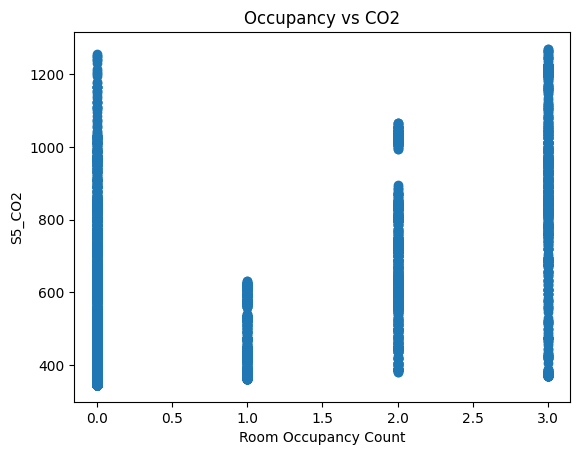

In [34]:
plt.scatter(df["Room_Occupancy_Count"], df["S5_CO2"])
plt.xlabel("Room Occupancy Count")
plt.ylabel("S5_CO2")
plt.title("Occupancy vs CO2")
plt.show()

### Interpretation

* Report “$r=…$, $p$-value=…; indicates \[weak/moderate/strong] \[positive/negative] correlation.”
* Show scatter to visualize linear trend.


## Question 4: Correlation Ambient Temp ↔ CO₂ & CO₂ Slope

**Goal:** AvgTemp vs. S5\_CO2 and vs. S5\_CO2\_Slope.

1. **Compute avg\_temp**:

In [35]:
df["avg_temp"] = df[["S1_Temp","S2_Temp","S3_Temp","S4_Temp"]].mean(axis=1)
df["avg_temp"].head()

0    24.9075
1    24.9225
2    24.9225
3    24.9375
4    24.9375
Name: avg_temp, dtype: float64

2. **Pearson tests average temp vs S5_CO2**:

In [36]:
r1, p1 = pearsonr(df["avg_temp"], df["S5_CO2"])
print(f"avg_temp vs S5_CO2: r = {r1:.4f}, p = {p1:.4f}")

avg_temp vs S5_CO2: r = 0.8287, p = 0.0000


3. **Pearson tests average temp vs S5_CO2_Slope**:

In [37]:
r2, p2 = pearsonr(df["avg_temp"], df["S5_CO2_Slope"])
print(f"avg_temp vs S5_CO2_Slope: r = {r2:.4f}, p = {p2:.4f}")

avg_temp vs S5_CO2_Slope: r = 0.1540, p = 0.0000


### Interpretation

* “Avg temp correlates with CO₂ at $r_1=…$ ($p_1=…$); with CO₂ slope at $r_2=…$ ($p_2=…$).”

## Question 5: OLS Regression for CO₂ Prediction

**Goal:** Predict S5\_CO2 from temps, lights, and occupancy.

1. **Select predictors**:

In [38]:
X = df[["S1_Temp","S2_Temp","S3_Temp","S4_Temp",
        "S1_Light","S2_Light","S3_Light","S4_Light",
        "Room_Occupancy_Count"]]
y = df["S5_CO2"]

2. **Fit OLS** (statsmodels):

In [39]:
X2 = sm.add_constant(X)
model = sm.OLS(y, X2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 S5_CO2   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     5769.
Date:                Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                        20:26:54   Log-Likelihood:                -58853.
No. Observations:               10129   AIC:                         1.177e+05
Df Residuals:                   10119   BIC:                         1.178e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9819.8631 

3. **Key outputs**:

   * **R²**: overall fit
   * **Coefficients** with p-values

4. **Pred vs. Actual plot**:

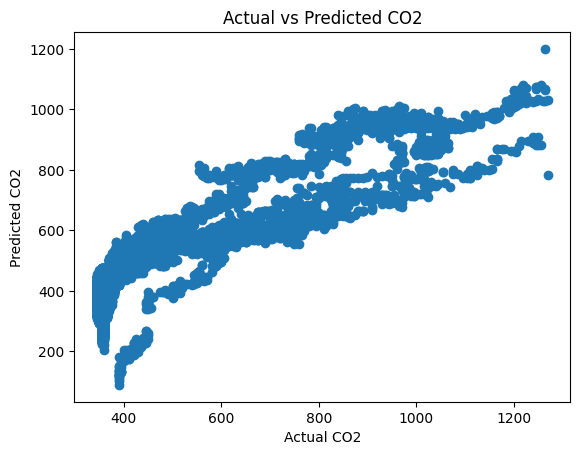

In [40]:
y_pred = model.predict(X2)
plt.scatter(y, y_pred)
plt.xlabel("Actual CO2")
plt.ylabel("Predicted CO2")
plt.title("Actual vs Predicted CO2")
plt.show()

### Interpretation

* Highlight the largest significant predictors (e.g. “each +1 °C in S2\_Temp ↦ +0.8 ppm CO₂, $p<0.01$”).
* Comment on R²: “Model explains \~X% of CO₂ variability.”

## Question 6: OLS Regression for Occupancy Prediction

**Goal:** Predict Room\_Occupancy\_Count from aggregates & sensors.

1. **Compute aggregates**:

In [41]:
df["avg_light"] = df[["S1_Light","S2_Light","S3_Light","S4_Light"]].mean(axis=1)
df["avg_sound"] = df[["S1_Sound","S2_Sound","S3_Sound","S4_Sound"]].mean(axis=1)

2. **Fit OLS**:

In [42]:
X = df[["avg_temp","avg_light","avg_sound","S5_CO2","S6_PIR","S7_PIR"]]
y = df["Room_Occupancy_Count"]
X2 = sm.add_constant(X)

occ_model = sm.OLS(y, X2).fit()
print(occ_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Room_Occupancy_Count   R-squared:                       0.810
Model:                              OLS   Adj. R-squared:                  0.810
Method:                   Least Squares   F-statistic:                     7199.
Date:                  Tue, 20 May 2025   Prob (F-statistic):               0.00
Time:                          20:26:54   Log-Likelihood:                -4817.7
No. Observations:                 10129   AIC:                             9649.
Df Residuals:                     10122   BIC:                             9700.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5687      0.467

### Interpretation

* Note which environmental factors best predict occupancy.
* If R² low or only one strong predictor, discuss “limited variation in occupancy counts may weaken model.”

---

## Putting It All Together

When you write up your report, emphasize:

* **Q1**: “Observed spike rate = … (95% CI: \[…,…]); normal approx OK; $p$-value=… → \[not] different from 2.5%.”
* **Q2**: “Mean = …°C (95% CI: \[…,…]); $t$-statistic=…, $p$=… → \[no] evidence mean ≠ 25°C.”
* **Q3–4**: Correlation coefficients with brief interpretation.
* **Q5**: R² and top 2–3 predictors—plot actual vs. predicted.
* **Q6**: R², significant predictors, note any occupancy data limitations.